In [ ]:
import time
import numpy as np
from scipy import linalg
import sympy as sym
import matplotlib.pyplot as plt
import ae353_cmg
import importlib
importlib.reload(ae353_cmg)

**Linearize Model**

In [2]:
# Choose desired angle
q_des = np.pi / 4.
# q_des =  np.pi / 2.

q1, q2, t2, v1, v2 = sym.symbols('q1, q2, t2, v1, v2')

t3 = 0.
v3 = 10. * np.pi / 3.

# Equilibrium values
q1_e = q_des
q2_e = 0.
t2_e = 0.
v1_e = 0.
v2_e = 0.

f = sym.Matrix([[v1],
                [v2],
                [-(5. * (200. * t3 * sym.sin(q2) + sym.sin(2. * q2) * v1 * v2 + 2. * sym.cos(q2) * v2 * v3)) / (10. * sym.sin(q2) ** 2. - 511.)],
                [10. * (100. * t2 - sym.cos(q2) * v1 * v3) / 11.]])

# Verify equilibrium
# f_num = sym.lambdify((q1, q2, t2, v1, v2), f)
# print(f_num(q1_e, q2_e, t2_e, t3_e, v1_e, v2_e))

# Find A and B
A_num = sym.lambdify((q1, q2, t2, v1, v2), f.jacobian([q1, q2, v1, v2]))
A = A_num(q1_e, q2_e, t2_e, v1_e, v2_e)
print(A)

B_num = sym.lambdify((q1, q2, t2, v1, v2), f.jacobian([t2]))
B = B_num(q1_e, q2_e, t2_e, v1_e, v2_e)
print(B)

[[ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.          0.20493103]
 [ 0.          0.         -9.51997774  0.        ]]
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [90.90909091]]


**Generate K**

In [ ]:
# Randomly generate K matrix
while True:
    K = np.random.rand(1, 4) * 5.
    F = A - B @ K
    s = linalg.eigvals(F)
    if (s.real < 0).all():
        print(s)
        break
print(K.tolist())

**Pre-Defined K Matrices**

The following values of K are known to work at given angles.

In [3]:
# 45 degrees (final)
K = np.array([[4.902197440056504, 4.0939320519147095, 1.408861483898759, 3.258604552702243]])

# 90 degrees (trial)
# K = np.array([[9.927411115966189, 4.392242552483563, 5.862501134582426, 3.419924688097828]])

**Controlling Rotor Torque**

This following code is an earlier attempt at a controller which controls both the gimbal torque and rotor torque.

In [ ]:
# Choose desired angle
q_des =  3. * np.pi / 2.

q1, q2, t2, t3, v1, v2 = sym.symbols('q1, q2, t2, t3, v1, v2')

v3 = 10. * np.pi / 3.

# Equilibrium values
q1_e = q_des
q2_e = 0.
t2_e = 0.
t3_e = 0.
v1_e = 0.
v2_e = 0.

f = sym.Matrix([[v1],
                [v2],
                [-(5. * (200. * t3 * sym.sin(q2) + sym.sin(2. * q2) * v1 * v2 + 2. * sym.cos(q2) * v2 * v3)) / (10. * sym.sin(q2) ** 2. - 511.)],
                [10. * (100. * t2 - sym.cos(q2) * v1 * v3) / 11.]])

# Verify equilibrium
# f_num = sym.lambdify((q1, q2, t2, t3, v1, v2), f)
# print(f_num(q1_e, q2_e, t2_e, t3_e, v1_e, v2_e))

# Find A and B
A_num = sym.lambdify((q1, q2, t2, t3, v1, v2), f.jacobian([q1, q2, v1, v2]))
A = A_num(q1_e, q2_e, t2_e, t3_e, v1_e, v2_e)
print(A)

B_num = sym.lambdify((q1, q2, t2, t3, v1, v2), f.jacobian([t2, t3]))
B = B_num(q1_e, q2_e, t2_e, t3_e, v1_e, v2_e)
print(B)

K = np.array([[17.052153845980854, 1.2621226965048582, 24.882294925499505, 7.085087074399499], [15.838899062179824, 8.210557821314069, 3.7508539247127324, 21.799822314758888]])

robot = ae353_cmg.RobotSimulator(damping=0., dt=0.001, display=True)

class RobotController:
    def __init__(self, K, q_des, dt=0.001):
        self.dt = dt
        self.K = K
        self.q_des = q_des
    
    def run(self, q_1, v_1, q_2, v_2, q_3, v_3):
        x = np.array([[q_1 - self.q_des], [q_2], [v_1], [v_2]])
        u = -self.K @ x
        tau_2 = u[0, 0]
        tau_3 = u[1, 0]
        return tau_2, tau_3

controller = RobotController(K, q_des, dt=robot.dt)

**Create PyBullet Instance**

In [4]:
robot = ae353_cmg.RobotSimulator(damping=0., dt=0.001, display=True)

**Define Controller**

In [5]:
class RobotController:
    def __init__(self, K, q_des, dt=0.001):
        self.dt = dt
        self.K = K
        self.q_des = q_des
    
    def run(self, q_1, v_1, q_2, v_2, q_3, v_3):
        x = np.array([[q_1 - self.q_des], [q_2], [v_1], [v_2]])
        u = -self.K @ x
        tau_2 = u[0, 0]
        tau_3 = 0.
        return tau_2, tau_3

controller = RobotController(K, q_des, dt=robot.dt)

**Run Simulation**

Code is adapted from CMGDemo.ipynb.

In [6]:
# Restore the simulation to its initial state
robot.reset(rotor_rpm=100.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q_1': np.empty(num_steps, dtype=float),
    'v_1': np.empty(num_steps, dtype=float),
    'q_2': np.empty(num_steps, dtype=float),
    'v_2': np.empty(num_steps, dtype=float),
    'q_3': np.empty(num_steps, dtype=float),
    'v_3': np.empty(num_steps, dtype=float),
    'tau_2': np.empty(num_steps, dtype=float),
    'tau_3': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_1, v_1, q_2, v_2, q_3, v_3 = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_2, tau_3 = controller.run(q_1, v_1, q_2, v_2, q_3, v_3)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q_1'][step] = q_1
    data['v_1'][step] = v_1
    data['q_2'][step] = q_2
    data['v_2'][step] = v_2
    data['q_3'][step] = q_3
    data['v_3'][step] = v_3
    data['tau_2'][step] = tau_2
    data['tau_3'][step] = tau_3
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau_2, tau_3)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

**Plot Results**

Code is adapted from CMGDemo.ipynb.

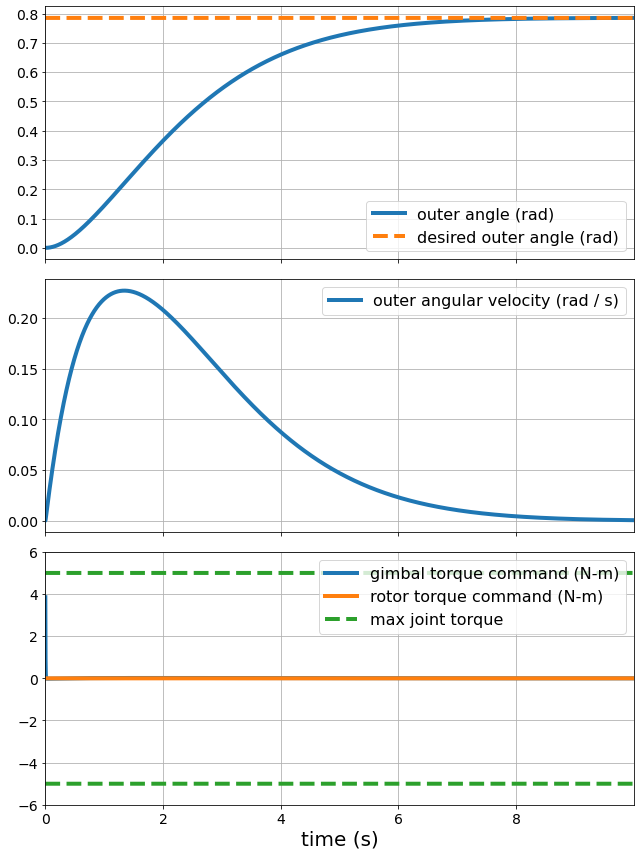

In [7]:
# Create a figure with three subplots, all of which share the same x-axis
fig, ax = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Plot angle of outer gimbal on first subplot
ax[0].plot(data['t'], data['q_1'], label='outer angle (rad)', linewidth=4)
ax[0].plot(data['t'],  np.ones_like(data['t']) * q_des, '--', label='desired outer angle (rad)', linewidth=4)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Plot angular velocity of outer gimbal on second subplot
ax[1].plot(data['t'], data['v_1'], label='outer angular velocity (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot torques on third subplot
ax[2].plot(data['t'], data['tau_2'], label='gimbal torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], data['tau_3'], label='rotor torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax[2].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)
ax[2].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[2].set_xlabel('time (s)', fontsize=20)
ax[2].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()